In [21]:
import random, sys, os, time
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction import DictVectorizer
from matplotlib import pyplot as plt

In [3]:
SEED = 1 # random seed to ensure reproducibility
DATA_LOCATION = 'Mimic3_Data'
LOG_LOCATION = 'ModelResults'

In [4]:
code_status_df = pd.read_parquet(f'{DATA_LOCATION}/code_status.parquet')
code_status_df.head()

,HADM_ID,LABEL,VALUE
0,150008,Code Status,Full Code
1,120815,Code Status,Full Code
2,194687,Code Status,Comfort Measures
3,151808,Code Status,Comfort Measures
4,185444,Code Status,Full Code


In [5]:
code_labels = {}
for i,row in code_status_df.iterrows():
    if row['VALUE'] is not None:
        if ('DNR' in row['VALUE']) or ('DNI' in row['VALUE']) or ('Comfort' in row['VALUE']) or ('Do Not' in row['VALUE']):
            label = 'DNR/CMO'
        elif (row['VALUE'] == 'Full Code') or (row['VALUE'] == 'Full code'):
            label = 'Full Code'
    code_labels[row['HADM_ID']] = label
print(set(code_status_df['VALUE'].values))

{None, 'Comfort measures only', 'CPR Not Indicate', 'Full code', 'Do Not Intubate', 'Other/Remarks', 'DNI (do not intubate)', 'DNR / DNI', 'DNR (do not resuscitate)', 'Full Code', 'Comfort Measures', 'Do Not Resuscita'}


In [6]:
def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'WHITE' in race:
        return 'White'
    return 'Other'

def normalize_insurance(insurance):
    if insurance in ['Medicare', 'Medicaid', 'Government']:
        return 'Public'
    else:
        return insurance

In [7]:
discharge_df = pd.read_parquet(f'{DATA_LOCATION}/discharge.parquet')
discharge_df = discharge_df[['HADM_ID', 'DISCHARGE_LOCATION']].drop_duplicates()

In [8]:
ama_labels = {}
for i,row in discharge_df.iterrows():
    if row['DISCHARGE_LOCATION'] == 'LEFT AGAINST MEDICAL ADVI':
        label = 'AMA'
    else:
        label = 'compliant'
    ama_labels[row['HADM_ID']] = label

In [9]:
mortality = pd.read_parquet(f'{DATA_LOCATION}/mortality.parquet')

# binary labels
mortality_labels = {}
for i,row in mortality.iterrows():
    if row['HOSPITAL_EXPIRE_FLAG']:
        label = 'deceased'
    else:
        label = 'survived'
    mortality_labels[row['HADM_ID']] = label

In [10]:
# combine all prediction targets into one DataFrame
all_labels = pd.merge(
    pd.merge(
        pd.DataFrame(ama_labels.items(), columns=['HADM_ID', 'AMA']),
        pd.DataFrame(code_labels.items(), columns=['HADM_ID', 'CS']),
        on='HADM_ID',
        how='outer'
    ),
    pd.DataFrame(mortality_labels.items(), columns=['HADM_ID', 'MORTALITY']),
    on='HADM_ID',
    how='outer'
).set_index('HADM_ID')
all_labels['AMA'] = np.where(all_labels['AMA'] == 'AMA', 1, 0)
all_labels['CS'] = np.where(all_labels['CS'] == 'DNR/CMO', 1, 0)
all_labels['MORTALITY'] = np.where(all_labels['MORTALITY'] == 'deceased', 1, 0)
#all_labels.head()

In [11]:
def data_split(ids, ratio=0.7, seed=SEED):
    random.seed(seed)
    random.shuffle(ids)
    train = ids[:int(len(ids)*ratio)]
    test  = ids[int(len(ids)*ratio):]
    return train, test

In [12]:
def analyze(task, vect, clf, count_top=False):

    ind2feat =  {i:f for f,i in vect.vocabulary_.items()}

    # create a 2-by-m matrix for biary, rather than relying on 1-p bullshit
    coef_ = clf.coef_
    
    # most informative features
    print(task)
    informative_feats = np.argsort(coef_)
    
    if len(informative_feats.shape) == 2:
        informative_feats = informative_feats[0,:]
        coef_ = coef_[0,:]
        
    # display what each feature is
    for feat in reversed(informative_feats):
        val = coef_[feat]

        word = ind2feat[feat]
        print('\t%-25s: %7.4f' % (word,val))

In [13]:
def compute_stats(pred, P, ref, labels_map):
    if len(labels_map) == 2:
        scores = P[:,1] - P[:,0]
        res = compute_stats_binary(pred, scores, ref, labels_map)
    else:
        res = compute_stats_multiclass(pred, P, ref, labels_map)
    return res

def compute_stats_binary(pred, probas, ref, labels_map):
    """
    Core function for calculating binary classification metrics.
    
    Parameters:
        pred (np.ndarray): Predicted labels (0 or 1)
        probas (np.ndarray): Model confidence scores for positive class
        ref (np.ndarray): Ground truth labels
        labels_map (dict): Mapping of label indices to class names
        
    Returns:
        dict: Dictionary containing accuracy, precision, recall, f1, 
              auc, sensitivity, and specificity
    """
    # Validate predictions match probability thresholds
    assert np.array_equal(pred, (probas > 0).astype(int)), "Predictions mismatch with probability thresholds"
    
    # Calculate confusion matrix using sklearn
    conf = confusion_matrix(ref, pred, labels=[0, 1])
    tn, fp, fn, tp = conf.ravel()
    
    # Compute metrics using sklearn functions
    precision = precision_score(ref, pred, zero_division=0)
    recall = recall_score(ref, pred, zero_division=0)
    f1 = f1_score(ref, pred, zero_division=0)
    accuracy = accuracy_score(ref, pred)
    specificity = tn / (tn + fp + 1e-9)
    
    # Calculate AUC if applicable
    auc = roc_auc_score(ref, probas) if len(np.unique(ref)) == 2 else None
    
    # Print formatted results
    '''print(f"\nTask: {task}")
    print(f"Confusion Matrix:\n{conf}")
    print(f"Specificity:\t{specificity:.3f}")
    print(f"Sensitivity:\t{recall:.3f}")  # Sensitivity = Recall
    if auc is not None:
        print(f"AUC:\t\t{auc:.3f}")
    print(f"Accuracy:\t{accuracy:.3f}")
    print(f"Precision:\t{precision:.3f}")
    print(f"F1 Score:\t{f1:.3f}")'''
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'sensitivity': recall,
        'specificity': specificity
    }

def compute_stats_multiclass(pred, P, ref, labels_map):
    # santiy check
    assert all(map(int,P.argmax(axis=1)) == pred)

    V = set(range(len(labels_map)))
    n = max(V)+1
    conf = np.zeros((n,n), dtype='int32')
    for p,r in zip(pred,ref):
        conf[p][r] += 1


    labels = [label for label,i in sorted(labels_map.items(), key=lambda t:t[1])]


    print(conf)
    
    precisions = []
    recalls = []
    f1s = []
    #print('\t prec  rec    f1   label')
    for i in range(n):
        label = labels[i]

        tp = conf[i,i]
        pred_pos = conf[i,:].sum()
        ref_pos  = conf[:,i].sum()

        precision   = tp / (pred_pos + 1e-9)
        recall      = tp / (ref_pos + 1e-9)
        f1 = (2*precision*recall) / (precision+recall+1e-9)

        #print(f'\t{precision:.3f} {recall:.3f} {f1:.3f} {label}')

        # Save info
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    avg_precision = sum(precisions) / len(precisions)
    avg_recall    = sum(recalls   ) / len(recalls   )
    avg_f1        = sum(f1s       ) / len(f1s       )
    #print('\t--------------------------')
    #print(f'\t{avg_precision:.3f} {avg_recall:.3f} {avg_f1:.3f} avg')
    
    res = {'precisions':precisions, 'recalls':recalls, 'f1s':f1s}

    return res

def true_positive_rate(pred, ref):
    tp,fn = 0,0
    for p,r in zip(pred,ref):
        if p==1 and r==1:
            tp += 1
        elif p==0 and r==1:
            fn += 1
    return tp / (tp + fn + 1e-9)


def false_positive_rate(pred, ref):
    fp,tn = 0,0
    for p,r in zip(pred,ref):
        if p==1 and r==0:
            fp += 1
        elif p==0 and r==0:
            tn += 1
    return fp / (fp + tn + 1e-9)

def classification_results(model, labels_map, X, Y):

    # for AUC
    P_ = model.decision_function(X)

    # sklearn has changes in API when doing binary classification. make it conform to 3+
    if len(labels_map)==2:
        m = X.shape[0]
        P = np.zeros((m,2))
        P[:,0] = -P_
        P[:,1] =  P_
    else:
        P = P_

    train_pred = P.argmax(axis=1)

    res = compute_stats(train_pred, P, Y, labels_map)
    return res
    
def regression_results(model, test_X, test_Y, description):
    res = {}
    
    pred_Y = model.predict(test_X)
    res['rms'] = mean_squared_error(test_Y, pred_Y)**0.5
    res['mas'] = mean_absolute_error(test_Y, pred_Y)
    '''if verbose:
        print(description)
        print('\tRMS:', res['rms'])
        print('\tMAS:', res['mas'])
    
        fig = plt.figure()
        perfect = np.arange(min(test_Y),max(test_Y),100)
        plt.scatter(perfect, perfect, color='red', s=0.01)
        plt.scatter(test_Y , pred_Y, color='blue', s=1)
        plt.xlabel('actual')
        plt.ylabel('prediction')
        plt.show()'''
    
    return res

In [14]:
def normalize(vec):
    return (vec - np.mean(vec))/np.std(vec)

oasis_df = pd.read_parquet(f'{DATA_LOCATION}/oasis_df.parquet')



In [15]:
outcomes_df = pd.read_parquet(f'{DATA_LOCATION}/outcomes.parquet')
outcomes_df['ETHNICITY'] = outcomes_df['ETHNICITY'].apply(normalize_race)
outcomes_df['INSURANCE'] = outcomes_df['INSURANCE'].apply(normalize_insurance)
outcomes_df = outcomes_df.rename(columns={'ETHNICITY': 'RACE', 'LOS_HOSPITAL': 'LOS'})
for col in ['AGE', 'OASIS', 'LOS']:
    outcomes_df[col] = normalize(outcomes_df[col])
outcomes_df.head()

,HADM_ID,INSURANCE,OASIS,NONCOMPLIANT,AUTOPSY,SENTIMENT,GENDER,AGE,RACE,ADMISSION_TYPE,LOS
0,134462,Public,0.922227,-5.270451,-1.931002,-0.569442,M,0.412972,Hispanic,EMERGENCY,-0.554881
1,119940,Private,0.020920,-6.017632,-0.203272,-0.552639,F,0.267922,White,EMERGENCY,-0.374724
2,176332,Private,-0.655060,-4.882203,-1.172165,-0.567575,M,0.358578,White,ELECTIVE,2.057401
3,108329,Public,0.922227,-5.436047,-1.139813,1.421746,F,0.594284,Black,EMERGENCY,0.435985
4,112077,Public,0.358910,-4.735420,-2.351723,-0.569975,M,-0.040309,White,EMERGENCY,-0.464803


In [16]:
def build_features(enabled):
    demographics_features = {}
    for i, row in outcomes_df.iterrows():
        feats = {}

        if 'admission_type' in enabled:
            feats[('admission_type', row['ADMISSION_TYPE'])] = 1
        if 'oasis' in enabled:
            feats[('oasis', None)] = row['OASIS']

        if 'age' in enabled:
            feats[('age', None)] = row['AGE']
        if 'los' in enabled:
            feats[('los', None)] = row['LOS']

        if 'insurance' in enabled:
            feats[('insurance', row['INSURANCE'])] = 1
        if 'gender' in enabled:
            feats[('gender', row['GENDER'])] = 1

        if 'race' in enabled:
            feats[('race', row['RACE'])] = 1
            
        if 'noncompliant' in enabled:
            feats[('noncompliant', None)] = row['NONCOMPLIANT']
        if 'autopsy' in enabled:
            feats[('autopsy', None)] = row['AUTOPSY']
        if 'sentiment' in enabled:
            feats[('sentiment', None)] = row['SENTIMENT']

        demographics_features[row['HADM_ID']] = feats

    # fit vectorizer
    vect = DictVectorizer()
    vect.fit(demographics_features.values())
    #print('num_features:', len(vect.feature_names_))

    # ordering of all features
    ids = demographics_features.keys()
    X = vect.transform([demographics_features[hadm_id] for hadm_id in ids])

    return demographics_features, vect

In [17]:
def random_string(length=6):
    """Generate a random string of fixed length."""
    random.seed()
    letters = 'abcdefghijklmnopqrstuvwxyz'
    return ''.join(random.choice(letters) for i in range(length))

In [18]:
def build_model(model_type, model_params, pred_type, target_labels_df, features, num_iterations=10):
    all_results = defaultdict(list)
    demographics_features, vect = build_features(features)
    ind2feat =  {i: f for f, i in vect.vocabulary_.items()}
    feature_weights = defaultdict(list)
    if pred_type == 'AMA':
        hadm_ids = list(set(discharge_df['HADM_ID'].values) & set(demographics_features.keys()))
    elif pred_type == 'CS':
        hadm_ids = list(set(code_labels.keys()) & set(demographics_features.keys()))
    elif pred_type == 'MORTALITY':
        hadm_ids = list(set(mortality_labels.keys()) & set(demographics_features.keys()))
    else:
        raise ValueError(f'Unsupported prediction type: {pred_type}')

    for i in range(num_iterations):
        
        train_ids, test_ids = data_split(hadm_ids, seed=i)

        # select pre-computed features
        train_features = [demographics_features[hadm_id] for hadm_id in train_ids]
        test_features  = [demographics_features[hadm_id] for hadm_id in test_ids]

        # vectorize features
        train_X = vect.transform(train_features)
        test_X = vect.transform(test_features)

        # select labels
        train_Y = [target_labels_df.loc[hadm_id, pred_type] for hadm_id in train_ids]
        test_Y = [target_labels_df.loc[hadm_id, pred_type] for hadm_id in test_ids]

        #print('patients:', len(hadm_ids))
        if model_type == 'lr':
            model = LogisticRegression(**model_params)
        elif model_type == 'gbm':
            model = GradientBoostingClassifier(**model_params)
        else:
            raise ValueError(f'Unsupported model type: {model_type}')

        model.fit(train_X, train_Y)

        res = classification_results(model, [0, 1], test_X, test_Y)
        for metric, value in res.items():
            all_results[metric].append(value)

        # append coefficients to feature_weights
        if model_type == 'lr':
            for feat,val in enumerate(model.coef_.tolist()[0]):
                featname = ind2feat[feat]
                feature_weights[featname].append(val)
        elif model_type == 'gbm':
            for feat,val in enumerate(model.feature_importances_):
                featname = ind2feat[feat]
                feature_weights[featname].append(val)
        #feature_weights.append(model)
    all_results = {k: round(np.mean(v), 4) for k, v in all_results.items() if len(v) > 0}
    feature_weights = {k: round(np.mean(v), 4) for k, v in feature_weights.items() if len(v) > 0}
    return all_results, feature_weights

def generate_report(params, all_results, feature_weights, filename=None):
    # Choose output: file if filepath is given, else stdout
    output = open(filename, 'w') if filename else sys.stdout
    try:
        print('Model Parameters:', file=output)
        for param, value in params.items():
            if isinstance(value, dict):
                for sub_param, sub_value in value.items():
                    print(f'\t{sub_param}: {sub_value}', file=output)
            else:
                print(f'\t{param}: {value}', file=output)
        print('Metrics:', file=output)
        for metric, value in all_results.items():
            print(f'\tAverage {metric}: {value}', file=output)
        print('Feature Weights:', file=output)
        for feat, weight in sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True):
            feat_print = feat[0] + '=' + feat[1] if feat[1] is not None else ''
            print(f'\t{feat}: {weight}', file=output)
    finally:
        if output != sys.stdout:
            output.close()
    

In [28]:
all_feature_combinations = [
    ['age', 'los', 'insurance', 'gender'],
    ['age', 'los', 'insurance', 'gender', 'race'],
    ['age', 'los', 'insurance', 'gender', 'noncompliant'],
    ['age', 'los', 'insurance', 'gender', 'autopsy'],
    ['age', 'los', 'insurance', 'gender', 'sentiment'],
    ['age', 'los', 'insurance', 'gender', 'race', 'noncompliant', 'autopsy', 'sentiment']
]
model_types = ['lr', 'gbm']
model_params = {
    'lr': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01},
    'gbm': {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 3,
        'random_state': SEED
    }
}
tabled_results = pd.DataFrame(columns=['model_type', 'pred_type', 'filename', 'model_params', 'features', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'sensitivity', 'specificity'])
for model_type in model_types:
    for features in all_feature_combinations:
        for pred_type in ['AMA', 'CS', 'MORTALITY']:
            results, weights = build_model(
                model_type,
                model_params[model_type],
                pred_type,
                all_labels,
                features,
                num_iterations=10
            )
            filename = f'{LOG_LOCATION}/{model_type}_{pred_type}_{random_string(6)}.txt'
            tabled_results.loc[len(tabled_results)] = [
                model_type,
                pred_type,
                filename,
                model_params[model_type],
                features,
                results['accuracy'],
                results['precision'],
                results['recall'],
                results['f1'],
                results['auc'],
                results['sensitivity'],
                results['specificity']
            ]
            generate_report(
                {'model_type': model_type, 'pred_type': pred_type, 'use_features': features, 'model_params': model_params[model_type]},
                results,
                weights,
                filename=filename
            )
            print(f'Completed {model_type} model for {pred_type} prediction with features: {features}')
tabled_results.to_csv(f'{LOG_LOCATION}/model_results.csv', index=False)
print('All results saved to:', f'{LOG_LOCATION}/model_results.csv')

Completed lr model for AMA prediction with features: ['age', 'los', 'insurance', 'gender']
Completed lr model for CS prediction with features: ['age', 'los', 'insurance', 'gender']
Completed lr model for MORTALITY prediction with features: ['age', 'los', 'insurance', 'gender']
Completed lr model for AMA prediction with features: ['age', 'los', 'insurance', 'gender', 'race']
Completed lr model for CS prediction with features: ['age', 'los', 'insurance', 'gender', 'race']
Completed lr model for MORTALITY prediction with features: ['age', 'los', 'insurance', 'gender', 'race']
Completed lr model for AMA prediction with features: ['age', 'los', 'insurance', 'gender', 'noncompliant']
Completed lr model for CS prediction with features: ['age', 'los', 'insurance', 'gender', 'noncompliant']
Completed lr model for MORTALITY prediction with features: ['age', 'los', 'insurance', 'gender', 'noncompliant']
Completed lr model for AMA prediction with features: ['age', 'los', 'insurance', 'gender', 'au

In [22]:
# HYPERPARAMETER TUNING FOR GBM
use_features = ['age', 'los', 'insurance', 'gender', 'race', 'noncompliant', 'autopsy', 'sentiment']
model_type = 'gbm'
pred_type = 'MORTALITY'
model_params_all_combinations = {
    'n_estimators': [10, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.02, 0.1, 0.2],
    'max_depth': [1, 3, 5, 8]
}
hyperparam_results = pd.DataFrame(columns=['model_type', 'pred_type', 'filename', 'n_estimators', 'learning_rate', 'max_depth', 'features', 'time_taken', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'sensitivity', 'specificity'])
for n_estimators in model_params_all_combinations['n_estimators']:
    for learning_rate in model_params_all_combinations['learning_rate']:
        for max_depth in model_params_all_combinations['max_depth']:
            model_params = {
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'random_state': SEED
            }
            start = time.time()
            results, weights = build_model(
                model_type,
                model_params,
                pred_type,
                all_labels,
                use_features,
                num_iterations=5
            )
            end = time.time()
            filename = f'{LOG_LOCATION}/gbm_{pred_type}_{random_string(6)}.txt'
            hyperparam_results.loc[len(hyperparam_results)] = [
                model_type,
                pred_type,
                filename,
                n_estimators,
                learning_rate,
                max_depth,
                use_features,
                round(end - start, 4),
                results['accuracy'],
                results['precision'],
                results['recall'],
                results['f1'],
                results['auc'],
                results['sensitivity'],
                results['specificity']
            ]
            generate_report(
                {'model_type': model_type, 'pred_type': pred_type, 'use_features': use_features, 'model_params': model_params},
                results,
                weights,
                filename=filename
            )
            print(f'Completed GBM model for {pred_type} prediction with params: {model_params}')

Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 1, 'random_state': 1}
Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 3, 'random_state': 1}
Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 1}
Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 8, 'random_state': 1}
Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.02, 'max_depth': 1, 'random_state': 1}
Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.02, 'max_depth': 3, 'random_state': 1}
Completed GBM model for MORTALITY prediction with params: {'n_estimators': 10, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 1}
Completed GBM model for MORTALITY predict

In [24]:
hyperparam_results.to_csv(f'{LOG_LOCATION}/gbm_hyperparam_results.csv', index=False)


In [26]:
for n_estimators in hyperparam_results['n_estimators'].unique():
    small_results = hyperparam_results[hyperparam_results['n_estimators'] == n_estimators]
    print(f'\nResults for n_estimators = {n_estimators}')
    display(small_results.pivot(index='learning_rate', columns='max_depth', values='auc'))


Results for n_estimators = 10


max_depth,1,3,5,8
learning_rate,,,,
0.01,0.5648,0.6794,0.7242,0.7220
0.02,0.5648,0.6866,0.7297,0.7280
0.10,0.6410,0.7327,0.7446,0.7429
0.20,0.6709,0.7451,0.7534,0.7427



Results for n_estimators = 50


max_depth,1,3,5,8
learning_rate,,,,
0.01,0.5650,0.7158,0.7372,0.7374
0.02,0.6437,0.7318,0.7450,0.7446
0.10,0.7075,0.7598,0.7602,0.7499
0.20,0.7300,0.7611,0.7562,0.7371



Results for n_estimators = 100


max_depth,1,3,5,8
learning_rate,,,,
0.01,0.6451,0.7317,0.7450,0.7451
0.02,0.6728,0.7458,0.7546,0.7512
0.10,0.7291,0.7619,0.7580,0.7443
0.20,0.7408,0.7597,0.7501,0.7295



Results for n_estimators = 200


max_depth,1,3,5,8
learning_rate,,,,
0.01,0.6725,0.7457,0.7545,0.7518
0.02,0.7009,0.7576,0.7610,0.7534
0.10,0.7402,0.7607,0.7531,0.7348
0.20,0.7455,0.7560,0.7391,0.7203



Results for n_estimators = 500


max_depth,1,3,5,8
learning_rate,,,,
0.01,0.7067,0.7595,0.7612,0.7527
0.02,0.7282,0.7620,0.7592,0.7480
0.10,0.7458,0.7559,0.7416,0.7178
0.20,0.7461,0.7451,0.7250,0.7065


<Axes: >

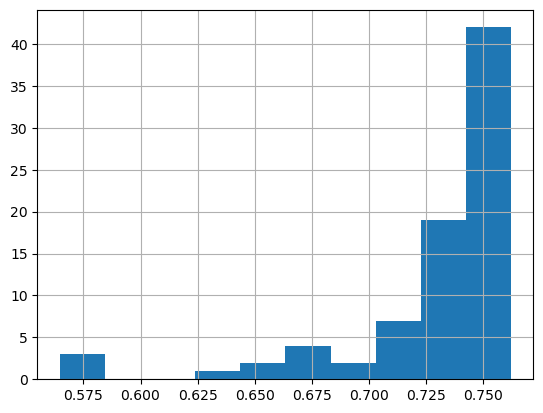

In [25]:
hyperparam_results['auc'].hist()